In [15]:
from __future__ import division
from __future__ import print_function
import os
import sys
from time import time
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import matplotlib.font_manager
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import pdist
from math import ceil
from pandas import Series
# Import all models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.lscp import LSCP
import warnings
warnings.filterwarnings("ignore")

# 测试Wine一个数据集情况，这里以wine_benchmark_0001.csv为例

In [16]:
wine_df=pd.read_csv("Outlier_wine/benchmarks/wine_benchmark_0001.csv",encoding="utf-8")
wine_df.head()

,point.id,motherset,origin,original.label,diff.score,ground.truth,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol
0,wine_point_3594,wine,regression,7,0.050492,nominal,-1.245962,-0.362411,-0.265853,-0.261304,-0.343495,1.209882,0.747594,-0.899276,0.817846,-0.613338,0.174560
1,wine_point_5089,wine,regression,5,0.082237,anomaly,0.759540,0.973867,0.215849,-0.534540,0.598458,-0.536656,0.199134,0.968217,0.071518,0.596292,-0.915394
2,wine_point_1912,wine,regression,6,0.290201,nominal,-0.088942,-0.969809,-0.403482,-0.870829,-0.429127,-0.592996,-0.791633,-0.699187,-1.110168,1.402712,-0.496181
3,wine_point_4908,wine,regression,5,0.053559,anomaly,0.219597,0.973867,0.284664,0.138039,0.427194,-0.762016,-0.243173,1.034913,0.817846,1.805921,0.006874
4,wine_point_2246,wine,regression,7,0.420300,nominal,0.219597,-0.180191,-0.541112,0.348220,-0.714567,-0.142276,0.446826,-0.242318,-0.363840,-1.016548,0.090717


**计算该csv的异常点和正常点的数量，确定异常点比例**

In [17]:
gt=wine_df["ground.truth"]
count = gt.value_counts()
gt=wine_df[["ground.truth"]]
print("该数据集异常点和正常点的数量\n"+str(count))

该数据集异常点和正常点的数量
nominal    2369
anomaly    1334
Name: ground.truth, dtype: int64


In [18]:
#拼接相关属性作为特征
wine_data1=wine_df.iloc[:,[4]]
wine_data2=wine_df.iloc[:,6:17]
wine_data=wine_data1.join(wine_data2)
wine_data.head()

,diff.score,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol
0,0.050492,-1.245962,-0.362411,-0.265853,-0.261304,-0.343495,1.209882,0.747594,-0.899276,0.817846,-0.613338,0.174560
1,0.082237,0.759540,0.973867,0.215849,-0.534540,0.598458,-0.536656,0.199134,0.968217,0.071518,0.596292,-0.915394
2,0.290201,-0.088942,-0.969809,-0.403482,-0.870829,-0.429127,-0.592996,-0.791633,-0.699187,-1.110168,1.402712,-0.496181
3,0.053559,0.219597,0.973867,0.284664,0.138039,0.427194,-0.762016,-0.243173,1.034913,0.817846,1.805921,0.006874
4,0.420300,0.219597,-0.180191,-0.541112,0.348220,-0.714567,-0.142276,0.446826,-0.242318,-0.363840,-1.016548,0.090717


# 将ground.truth中的正常值设为0，异常值设为1

In [19]:
gt.loc[gt["ground.truth"]=="nominal"]=0
gt.loc[gt["ground.truth"]=="anomaly"]=1


In [20]:
wine_data=wine_data.values #dataframe矩阵化
print(wine_data)

[[ 0.05049202 -1.2459619  -0.36241058 ...  0.8178459  -0.61333787
   0.1745595 ]
 [ 0.08223729  0.75953972  0.97386683 ...  0.07151784  0.5962918
  -0.91539371]
 [ 0.29020107 -0.08894173 -0.9698094  ... -1.11016825  1.40271158
  -0.49618094]
 ...
 [ 0.06631019  0.60527037  1.52052576 ...  1.25320393  2.61234125
   0.00687439]
 [ 0.62122628 -0.47461512  0.0627686  ... -0.73700422 -0.41173293
  -0.91539371]
 [ 0.15118924 -0.62888448  1.76348529 ...  2.248308    0.86509839
  -0.58002349]]


In [21]:
#定义用于检测异常值的算法
random_state = np.random.RandomState(42)
outliers_fraction=count[1]/(count[0]+count[1])
classifiers = {
    'Cluster-based Local Outlier Factor (CBLOF)':
        CBLOF(contamination=outliers_fraction,
              check_estimator=False, random_state=random_state),
        'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=35),
                       contamination=outliers_fraction,
                       random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(
        contamination=outliers_fraction),
    'Average KNN': KNN(method='mean',
                       contamination=outliers_fraction),
    'Local Outlier Factor (LOF)':
        LOF(n_neighbors=35, contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state),
 
}

In [22]:
for i, clf in enumerate(classifiers.keys()):
    print('Model', i + 1, clf)

Model 1 Cluster-based Local Outlier Factor (CBLOF)
Model 2 Feature Bagging
Model 3 Histogram-base Outlier Detection (HBOS)
Model 4 Isolation Forest
Model 5 K Nearest Neighbors (KNN)
Model 6 Average KNN
Model 7 Local Outlier Factor (LOF)
Model 8 Minimum Covariance Determinant (MCD)
Model 9 One-class SVM (OCSVM)
Model 10 Principal Component Analysis (PCA)


**下面的异常点检测分两种，一种划分训练集和测试集，一种不划分，整体测试；分别调用CBLOF，FB，HBOS，IF，AVG_KNN，Loc KNN，LOF，MCD，OCSVM，PCA算法对该csv进行异常点检测，检测的结果通过ROC曲线和AUC值来评价**

1 fitting Cluster-based Local Outlier Factor (CBLOF)
内点:2369  外点:1334
总误差值1516
AUC值为0.5559089387345162


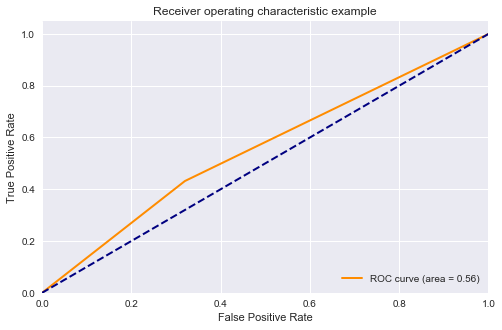

2 fitting Feature Bagging
内点:2429  外点:1274
总误差值1528
AUC值为0.5484891806423301


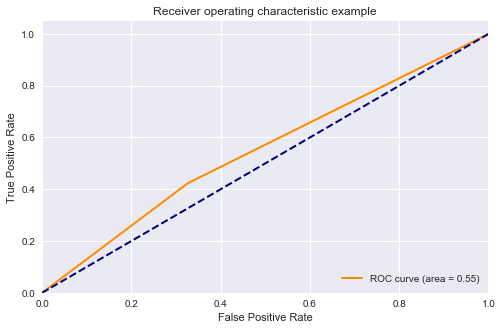

3 fitting Histogram-base Outlier Detection (HBOS)
内点:2369  外点:1334
总误差值1374
AUC值为0.5975058587211248


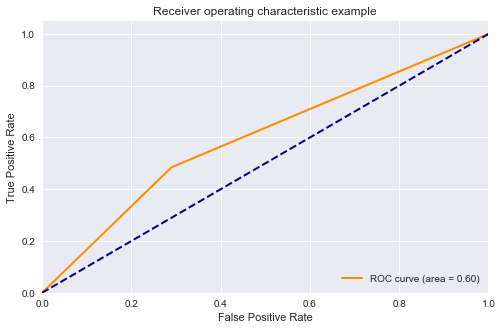

4 fitting Isolation Forest
内点:2369  外点:1334
总误差值1482
AUC值为0.5658687646468028


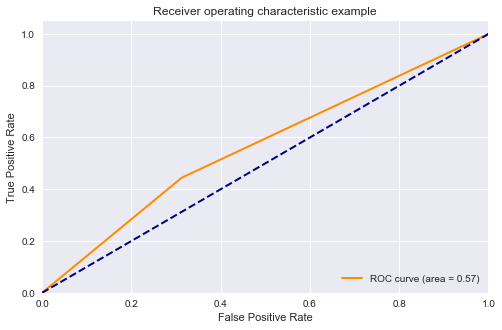

5 fitting K Nearest Neighbors (KNN)
内点:2552  外点:1151
总误差值1509
AUC值为0.5462372231860533


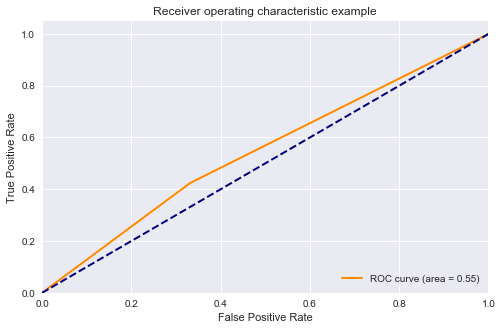

6 fitting Average KNN
内点:3253  外点:450
总误差值1366
AUC值为0.5593049151210848


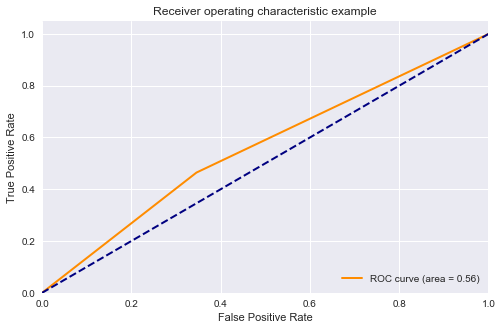

7 fitting Local Outlier Factor (LOF)
内点:2408  外点:1295
总误差值1561
AUC值为0.540064649366975


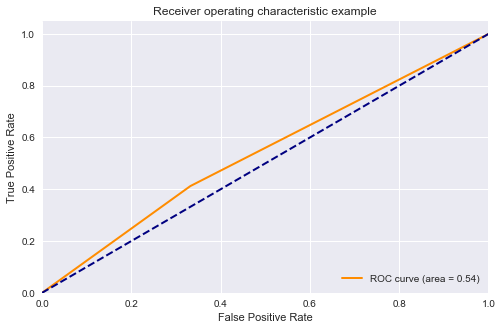

8 fitting Minimum Covariance Determinant (MCD)
内点:2368  外点:1335
总误差值1327
AUC值为0.6113193073691668


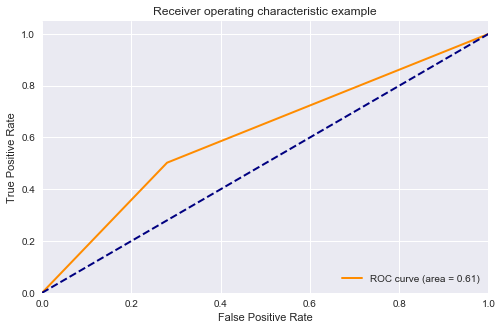

9 fitting One-class SVM (OCSVM)
内点:2369  外点:1334
总误差值1588
AUC值为0.5348175426849682


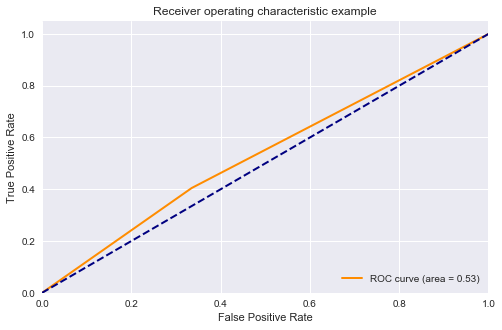

10 fitting Principal Component Analysis (PCA)
内点:2370  外点:1333
总误差值1493
AUC值为0.5625851083023921


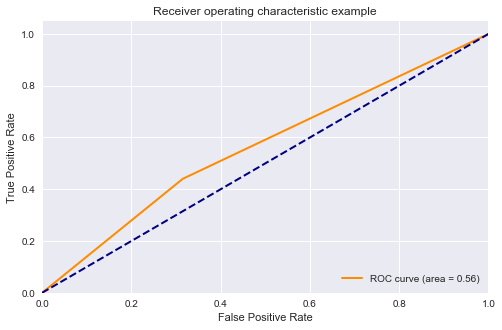

In [23]:
##########################################
###########不划分训练集和测试集###########
##########################################
from sklearn.metrics import roc_curve, auc
algorithm_list=pd.DataFrame(columns=['CBLOF' ,'FB','HBOS','IF','AVG_KNN','Loc KNN','LOF','MCD','OCSVM','PCA'])

temp=0
df_array=[]

for i, (clf_name, clf) in enumerate(classifiers.items()):
    print(i + 1, 'fitting', clf_name)
    # fit the data and tag outliers
    clf.fit(wine_data)
    scores_pred = clf.decision_function(wine_data) * -1
    y_pred = clf.predict(wine_data)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    threshold = percentile(scores_pred, 100 * outliers_fraction)
    print("内点:"+str(n_inliers)+"  "+"外点:"+str(n_outliers))

    n_errors = (y_pred.flatten() != gt.values.flatten()).sum()#计算ground.truth和预测值之间不匹配的个数
    # plot the levels lines and the points
    print("总误差值"+str(n_errors))
    fpr, tpr, threshold = roc_curve(y_pred, gt.values.flatten())  ###计算真正率和假正率
    roc_auc = auc(fpr, tpr)  ###计算auc的值
    print("AUC值为"+str(roc_auc))
    df_array.append(roc_auc)

    lw = 2
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)  ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

algorithm_list.loc[temp]=df_array

In [24]:
#以列表的形式展出
algorithm_list.index=["wine_benchmarks_0001.csv"]
algorithm_list.head()

,CBLOF,FB,HBOS,IF,AVG_KNN,Loc KNN,LOF,MCD,OCSVM,PCA
wine_benchmarks_0001.csv,0.555909,0.548489,0.597506,0.565869,0.546237,0.559305,0.540065,0.611319,0.534818,0.562585


**各算法在0001.csv上的性能如上，可以看到，在划分训练集的基础上，除了MCD算法的AUC值上了0.6以外，其余算法的值都在0.5-0.6之间，性能一般，其主要原因个人觉得在于异常点的检测数量上，因为每个csv的异常点数量不一样，从占整体10%~40%不等，异常点的数量影响了算法的性能，当然也有可能是算法本身对于这种多维数据处理性能一般。**

1 fitting Cluster-based Local Outlier Factor (CBLOF)
内点:455  外点:284
总339
AUC值为0.503741680854357


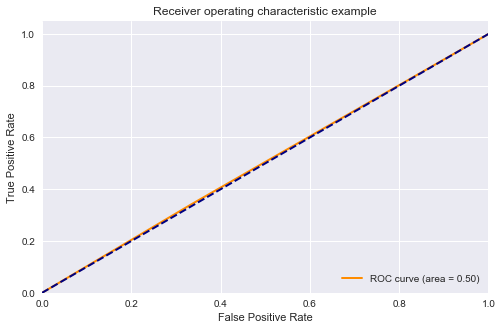

2 fitting Feature Bagging
内点:445  外点:294
总343
AUC值为0.5026522968738056


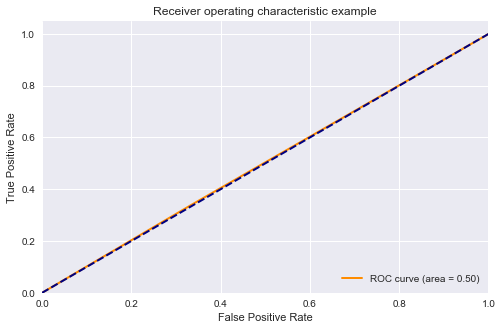

3 fitting Histogram-base Outlier Detection (HBOS)
内点:467  外点:272
总335
AUC值为0.5039323277490867


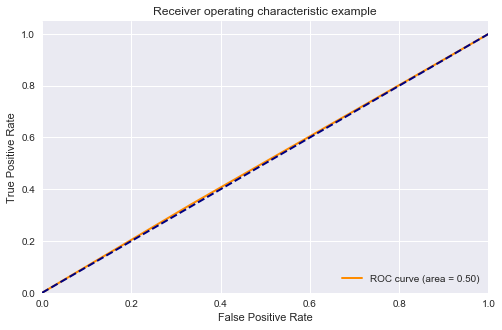

4 fitting Isolation Forest
内点:453  外点:286
总345
AUC值为0.49610599113910375


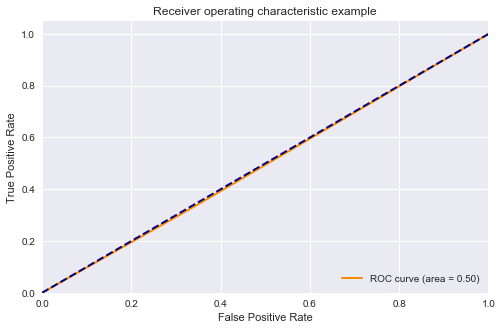

5 fitting K Nearest Neighbors (KNN)
内点:462  外点:277
总342
AUC值为0.4961515620360386


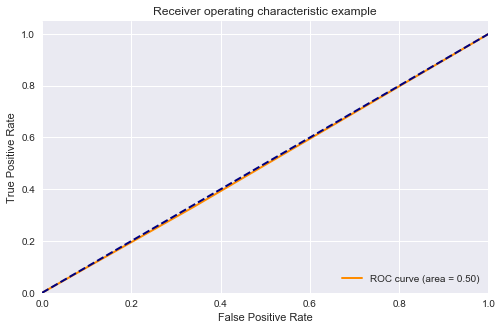

6 fitting Average KNN
内点:468  外点:271
总336
AUC值为0.5020066546819315


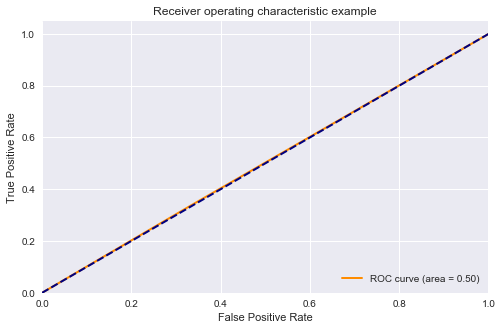

7 fitting Local Outlier Factor (LOF)
内点:450  外点:289
总338
AUC值为0.5074548250672818


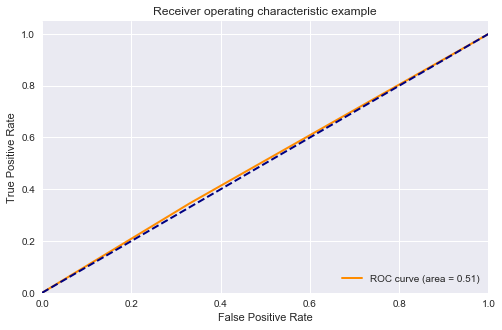

8 fitting Minimum Covariance Determinant (MCD)
内点:462  外点:277
总328
AUC值为0.516362698673168


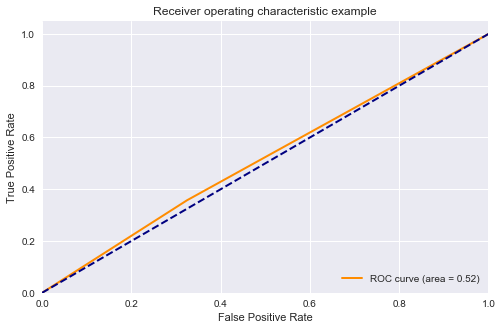

9 fitting One-class SVM (OCSVM)
内点:461  外点:278
总337
AUC值为0.5038351097863575


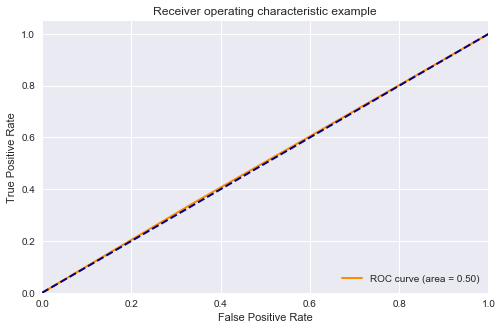

10 fitting Principal Component Analysis (PCA)
内点:466  外点:273
总330
AUC值为0.5116610856954205


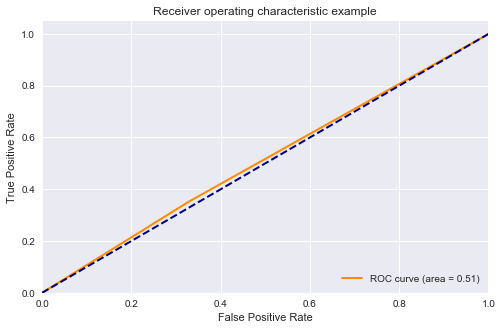

In [26]:
##########################################
###########划分训练集和测试集#############
##########################################
index = [i for i in range(len(wine_data))] # 划分训练测试集
np.random.shuffle(index) # 打乱索引
wine_data = wine_data[index]
label=gt.values

algorithm_list=pd.DataFrame(columns=['CBLOF' ,'FB','HBOS','IF','AVG_KNN','Loc KNN','LOF','MCD','OCSVM','PCA'])
temp=0
df_array=[]

wine_data_train=wine_data[0:int(len(wine_data)*0.8),:]
wine_data_test=wine_data[int(len(wine_data)*0.8)+1:len(wine_data)-1,:]
label_test=label[int(len(wine_data)*0.8)+1:len(wine_data)-1,:]

from sklearn.metrics import roc_curve, auc
for i, (clf_name, clf) in enumerate(classifiers.items()):
    print(i + 1, 'fitting', clf_name)
    # fit the data and tag outliers
    clf.fit(wine_data_train)
    scores_pred = clf.decision_function(wine_data_train) * -1
    y_pred = clf.predict(wine_data_test)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    threshold = percentile(scores_pred, 100 * outliers_fraction)
    print("内点:"+str(n_inliers)+"  "+"外点:"+str(n_outliers))

    n_errors = (y_pred.flatten() != label_test.flatten()).sum()
    # plot the levels lines and the points
    print("总"+str(n_errors))
    fpr, tpr, threshold = roc_curve(y_pred, label_test.flatten())  ###计算真正率和假正率
    roc_auc = auc(fpr, tpr)  ###计算auc的值
    df_array.append(roc_auc)
    print("AUC值为"+str(roc_auc))
    
    lw = 2
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)  ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
algorithm_list.loc[temp]=df_array

In [27]:
algorithm_list.index=["wine_benchmarks_0001.csv"]
algorithm_list.head()

,CBLOF,FB,HBOS,IF,AVG_KNN,Loc KNN,LOF,MCD,OCSVM,PCA
wine_benchmarks_0001.csv,0.503742,0.502652,0.503932,0.496106,0.496152,0.502007,0.507455,0.516363,0.503835,0.511661


**若划分了测试集和训练集，从上面算法的性能可以看出效果一点都不好，在0.50左右徘徊，基本等于瞎猜，所以在总体全部csv上还是采用全数据拟合的方式来检测异常值**